In [256]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Data Fields
- datetime - hourly date + timestamp  
- season: 
         - 1 = spring, 
         - 2 = summer, 
         - 3 = fall, 
         - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather: 
          - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
          - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals **(target)**

In [257]:
train_df = pd.read_csv("./train.csv", parse_dates=["datetime"])

## Data Summary
3 simple steps on the dataset

1. size of the dataset
2. get data by printing few rows of it
3. what type of variables 

In [258]:
train_df.shape

(10886, 12)

In [259]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [260]:
train_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

## Feature Engineering
"season", "holiday", "workingday", "weather" $\rightarrow$ "categorical" data, But now their type are "int"

1. Create new columns **"date", "hour", "weekday", "month"** from "datetime" column
2. Coerce the datatype of "season", "holiday", "workingday" "weather" to **category**
3. **Drop** the **datetime column** as we already extracted useful features from it.

In [261]:
train_df["date"] = train_df["datetime"].dt.date
train_df["hour"] = train_df["datetime"].dt.hour
train_df["weekday"] = train_df["datetime"].dt.weekday
train_df["month"] = train_df["datetime"].dt.month

In [262]:
def changeSeason(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    
train_df.season = train_df.month.apply(changeSeason)

### Coercing To Category Type

In [263]:
category_li = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in category_li:
    train_df[var] = train_df[var].astype("category")
train_df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
date                  object
hour                category
weekday             category
month               category
dtype: object

### Dropping Unnecessary Column

In [264]:
train_df = train_df.drop(["datetime"], axis=1)

## Missing Values Analysis
No missing values in this Dataset

In [265]:
train_df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

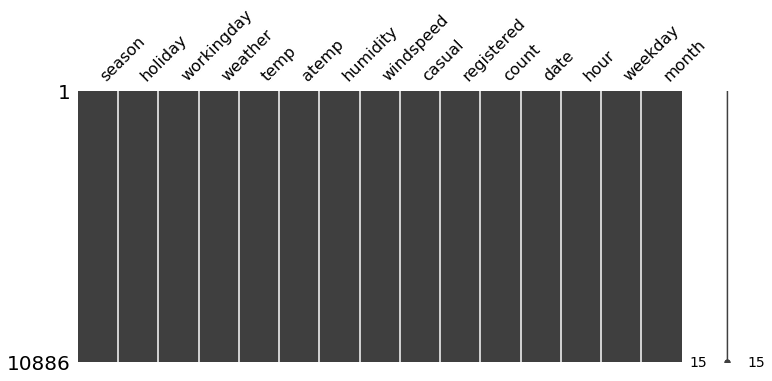

In [266]:
msno.matrix(train_df, figsize=(12, 5))

## Outliers Analysis

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

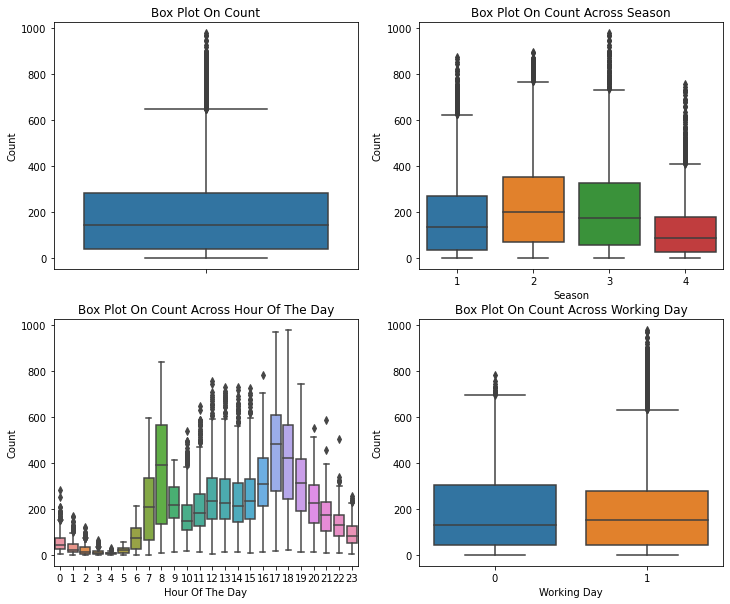

In [267]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train_df, y="count", orient='v', ax=axes[0][0])
sn.boxplot(data=train_df, y="count", x="season", orient='v', ax=axes[0][1])
sn.boxplot(data=train_df, y="count", x="hour",orient='v', ax=axes[1][0])
sn.boxplot(data=train_df, y="count", x="workingday",orient='v', ax=axes[1][1])

axes[0][0].set(ylabel="Count", title="Box Plot On Count")
axes[0][1].set(xlabel="Season", ylabel="Count", title="Box Plot On Count Across Season")
axes[1][0].set(xlabel="Hour Of The Day", ylabel="Count", title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel="Working Day", ylabel="Count", title="Box Plot On Count Across Working Day")


### Lets Remove Outliers In The Count Column

In [268]:
trainDfWithOutliers = train_df[np.abs(train_df["count"]-train_df["count"].mean()) <= (3*train_df["count"].std())]

In [269]:
print("Shape Of the Before Outliers:", train_df.shape)
print("Shape Of the After Outliers:", trainDfWithOutliers.shape)

Shape Of the Before Outliers: (10886, 15)
Shape Of the After Outliers: (10739, 15)


## Correlation Analysis

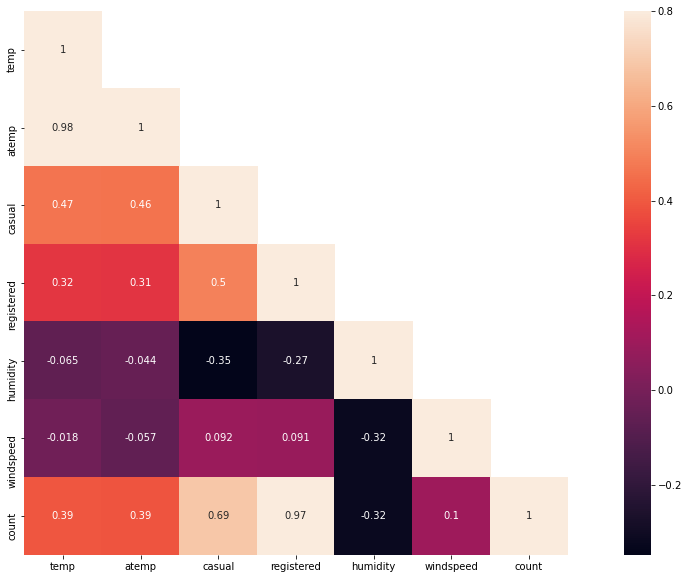

In [270]:
corrMatt = train_df[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

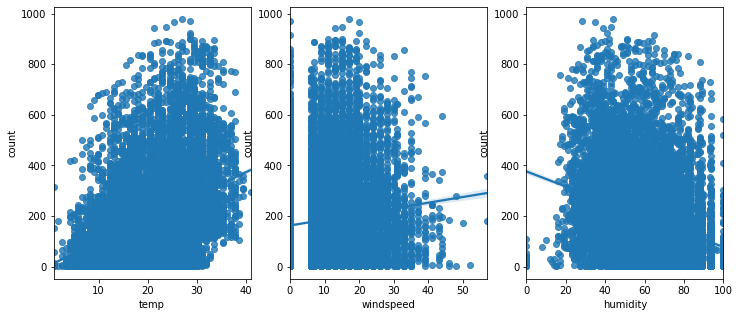

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sn.regplot(x="temp", y="count", data=train_df, ax=ax1)
sn.regplot(x="windspeed", y="count", data=train_df, ax=ax2)
sn.regplot(x="humidity", y="count", data=train_df, ax=ax3)

## Visualizing Distribution Of Data

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244168, 4.591363690454027, 0.9611793780126955))

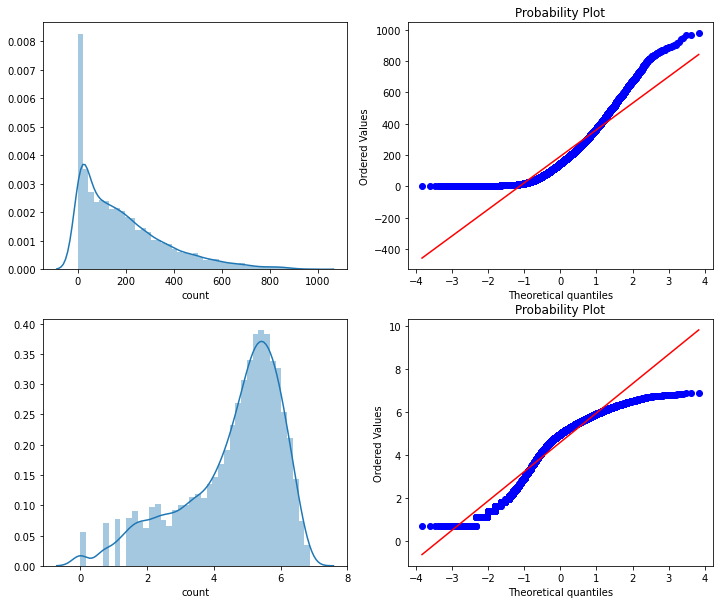

In [272]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(train_df["count"],ax=axes[0][0])
stats.probplot(train_df["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(train_df["count"]),ax=axes[1][0])
stats.probplot(np.log1p(train_df["count"]), dist='norm', fit=True, plot=axes[1][1])

### Visualizing Count V.S Month, Season, Hour, Weekday, Usertype

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

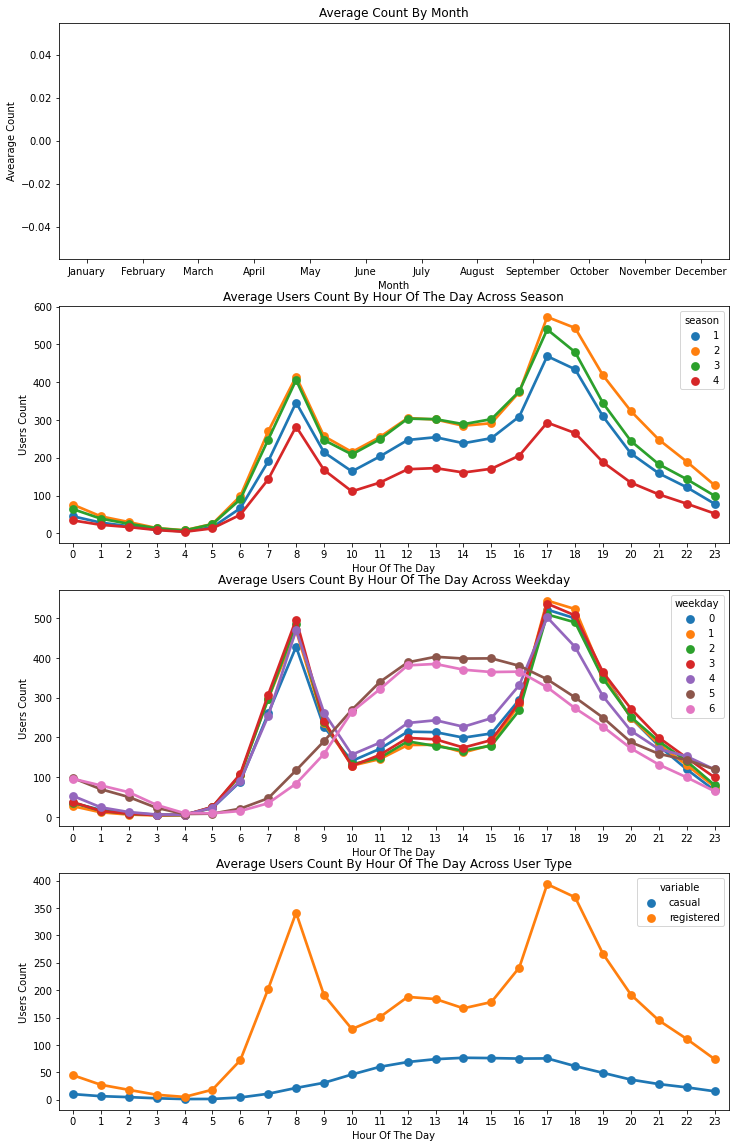

In [273]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train_df.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count", ascending=False)
sn.barplot(data=monthSorted,x="month", y="count", ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count', title="Average Count By Month")

hourAggregated = pd.DataFrame(train_df.groupby(["hour", "season"])["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["season"], data=hourAggregated,
            join=True, ax=ax2)
ax2.set(xlabel="Hour Of The Day", ylabel="Users Count", title="Average Users Count By Hour Of The Day Across Season", label="big")

hourAggregated = pd.DataFrame(train_df.groupby(["hour", "weekday"])["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["weekday"], data=hourAggregated,
            join=True, ax=ax3)
ax3.set(xlabel="Hour Of The Day", ylabel="Users Count", title="Average Users Count By Hour Of The Day Across Weekday", label="big")


hourTransformed = pd.melt(train_df[["hour", "casual", "registered"]], id_vars=["hour"], value_vars=["casual", "registered"])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"], sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"], hue=hourAggregated["variable"],
             hue_order=["casual","registered"], data=hourAggregated, join=True, ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',
        title="Average Users Count By Hour Of The Day Across User Type",label='big')

## Filling Outliers in "windspeed" Using Random Forest

In [274]:
dataTrain = pd.read_csv("./train.csv", parse_dates=["datetime"])
dataTest = pd.read_csv("./test.csv", parse_dates=["datetime"])

In [275]:
data = pd.concat([dataTrain, dataTest])
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [276]:
data["date"] = data["datetime"].dt.date
data["hour"] = data["datetime"].dt.hour
data["year"] = data["datetime"].dt.year
data["weekday"] = data["datetime"].dt.weekday
data["month"] = data["datetime"].dt.month

Random Forest Model To Predict 0's in "windspeed"

In [277]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"] == 0]
dataWindNot0 = data[data["windspeed"] != 0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop("index", inplace=True, axis=1)

Coercing To Categorical Type

In [278]:
categoricalFeatureNames = ["season", "holiday", "workingday", "weather", "weekday", "month", "year", "hour"]
numericalFeatureNames = ["temp", "atemp", "humidity", "windspeed"]
dropFeatures = ["casual", "count", "datetime", "date", "registered"]

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [279]:
dataTrain = data[pd.notnull(data["count"])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data["count"])].sort_values(by=["datetime"])
 
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLabelsCasual = dataTrain["casual"]

In [280]:
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

In [281]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(y + 1)]))
    log2 = np.nan_to_num(np.array([np.log(y_ + 1)]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Linear Regression Model

In [282]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [283]:
lModel = LinearRegression()
yLabelsLog = np.log1p(yLabels)
lModel.fit(X=dataTrain, y=yLabelsLog)

preds = lModel.predict(X=dataTrain)
print("RMSLE Value For Linear Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds)))

RMSLE Value For Linear Regression:  0.9779753340040555


## Regularization Model - Ridge

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779753189405841


KeyError: 'parameters'

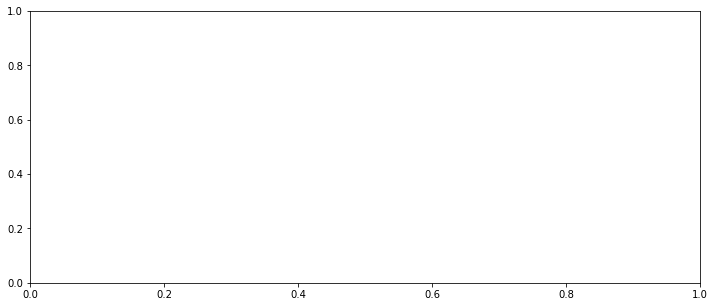

In [284]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X=dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Regularization Model - Lasso

{'alpha': 0.0033333333333333335, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.978097426343876


KeyError: 'parameters'

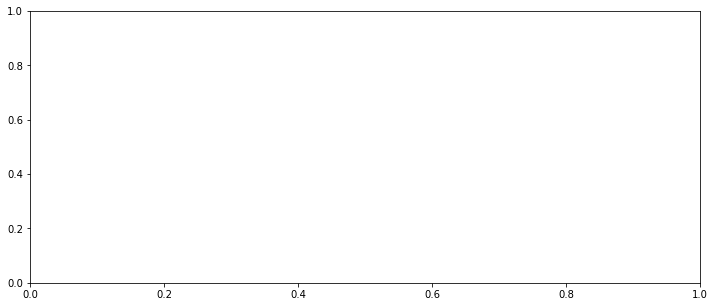

In [286]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Ensemble Models - Random Forest

In [287]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X=dataTrain)
print("RMSE Value For Random Forest: ", rmsle(np.exp(yLabelsLog), np.exp(preds)))

RMSE Value For Random Forest:  0.10299731387830345


## Ensemble Model - Gradient Boost

In [285]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain, yLabelsLog)
preds = gbm.predict(X=dataTrain)
print("RMSLE Value For Gradient Boost: ", rmsle(np.exp(yLabelsLog), np.exp(preds)))

RMSLE Value For Gradient Boost:  0.18947190261594168


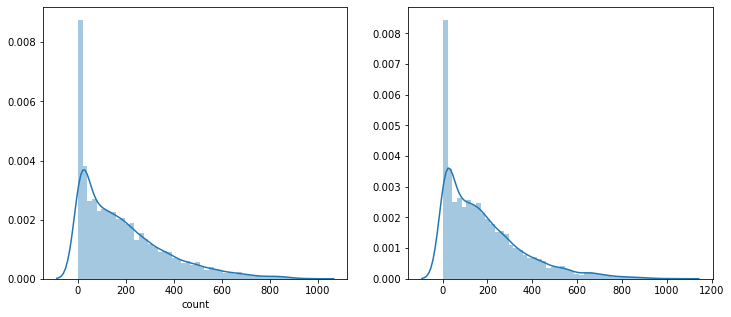

In [288]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [289]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)